In [1]:
import importlib
from typing import Optional
from typing import Tuple, Dict

import numpy as np
import pandas as pd
from monai.visualize import matshow3d
from torch.utils.data import DataLoader

from meningioma_dl.config import Config
from meningioma_dl.data_loading import data_loader
from meningioma_dl.data_loading.data_loader import TransformationsMode

## Global constants definition

## Create Data Loader

In [4]:
def get_data_loader(
    transformations_mode: TransformationsMode, ci_run: bool = True
) -> DataLoader:
    importlib.reload(data_loader)

    if ci_run:
        labels_file_path_train = Config.ci_run_labels_file_path
        data_root_directory = Config.ci_images_directory
    else:
        labels_file_path_train = Config.train_labels_file_path
        data_root_directory = Config.images_directory

    training_data_loader, _ = data_loader.get_data_loader(
        labels_file_path_train,
        data_root_directory,
        num_workers=1,
        transformations_mode=transformations_mode,
        batch_size=1,
    )
    return training_data_loader

## Basic visualization

In [5]:
training_data_loader = get_data_loader(TransformationsMode.ONLY_PREPROCESSING)
data_loader_iter = iter(training_data_loader)
number_of_samples = len(training_data_loader)

# data = next(data_loader_iter)
# data["img"].shape

[<monai.transforms.io.dictionary.LoadImaged object at 0x000001D77532ECD0>, <monai.transforms.spatial.dictionary.Orientationd object at 0x000001D70506AE80>, <monai.transforms.spatial.dictionary.Spacingd object at 0x000001D705307A60>, <monai.transforms.croppad.dictionary.CropForegroundd object at 0x000001D704654280>, <monai.transforms.croppad.dictionary.SpatialPadd object at 0x000001D70409AB50>, <monai.transforms.spatial.dictionary.Zoomd object at 0x000001D705A5EF10>, <monai.transforms.intensity.dictionary.MaskIntensityd object at 0x000001D7043D82B0>, <monai.transforms.intensity.dictionary.ScaleIntensityd object at 0x000001D704721610>, <monai.transforms.spatial.dictionary.Resized object at 0x000001D7043B5280>]


In [8]:
from matplotlib import pyplot as plt
from pathlib import Path


def visualize_image(data: np.array, save_path:Optional[Path]=None):
    print(f"image shape: {data.shape}")

    fig = plt.figure()
    # matshow3d(
    #     volume=data,
    #     fig=fig,
    #     title="input image",
    #     figsize=(100, 100),
    #     every_n=40,
    #     frame_dim=-1,
    #     cmap="gray",
    #     show=False
    # )
    image = data[0][0]
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    sagittal_slice = image[:, image.shape[1] // 2, :]
    axes[0].imshow(sagittal_slice, cmap='gray')
    axes[0].set_title('Sagittal Slice')
    axes[0].axis('off')

    coronal_slice = image[image.shape[0] // 2, :, :]
    axes[1].imshow(coronal_slice, cmap='gray')
    axes[1].set_title('Coronal Slice')
    axes[1].axis('off')

    axial_slice = image[:, :, image.shape[2] // 2]
    axes[2].imshow(axial_slice, cmap='gray')
    axes[2].set_title('Axial Slice')
    axes[2].axis('off')

    if save_path is not None:
        fig.savefig(str(save_path))
    else:
        fig.show()

[<monai.transforms.io.dictionary.LoadImaged object at 0x000001D710A7F0A0>, <monai.transforms.spatial.dictionary.Orientationd object at 0x000001D710E9BC70>, <monai.transforms.spatial.dictionary.Spacingd object at 0x000001D7135FCF70>, <monai.transforms.croppad.dictionary.CropForegroundd object at 0x000001D7135FCA30>, <monai.transforms.croppad.dictionary.SpatialPadd object at 0x000001D7135FC8B0>, <monai.transforms.spatial.dictionary.Zoomd object at 0x000001D7135FC550>, <monai.transforms.intensity.dictionary.MaskIntensityd object at 0x000001D7135FC790>, <monai.transforms.intensity.dictionary.ScaleIntensityd object at 0x000001D7135FC700>, <monai.transforms.intensity.dictionary.RandGaussianNoised object at 0x000001D7135FCEB0>, <monai.transforms.intensity.dictionary.MaskIntensityd object at 0x000001D7135FC4F0>, <monai.transforms.spatial.dictionary.Resized object at 0x000001D7135FC070>]
image shape: torch.Size([1, 1, 224, 224, 224])
image shape: torch.Size([1, 1, 224, 224, 224])
image shape: t

<Figure size 640x480 with 0 Axes>

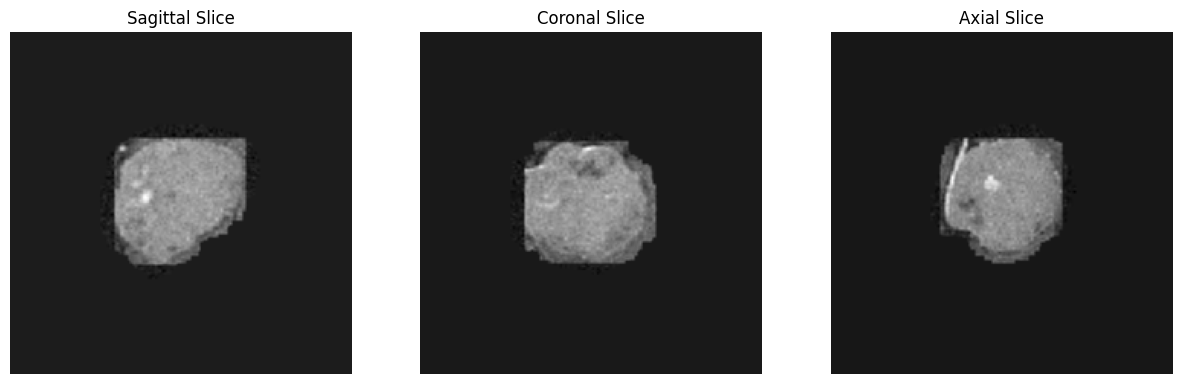

<Figure size 640x480 with 0 Axes>

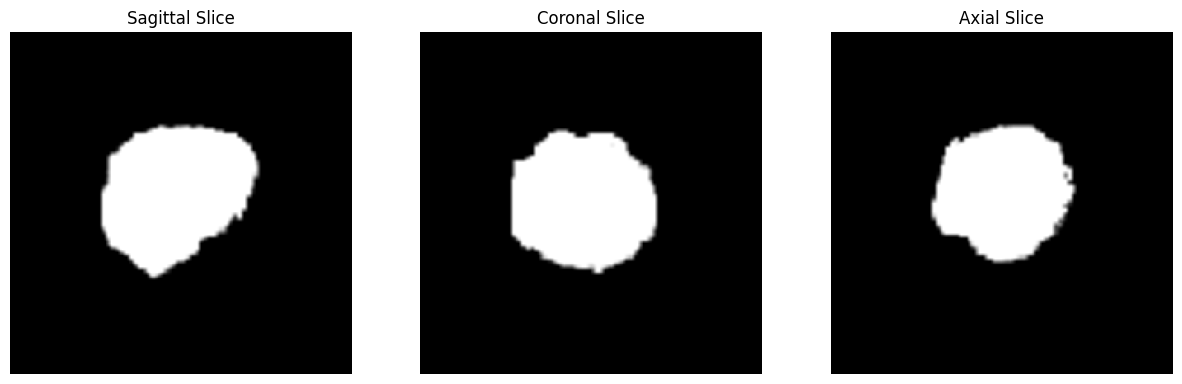

<Figure size 640x480 with 0 Axes>

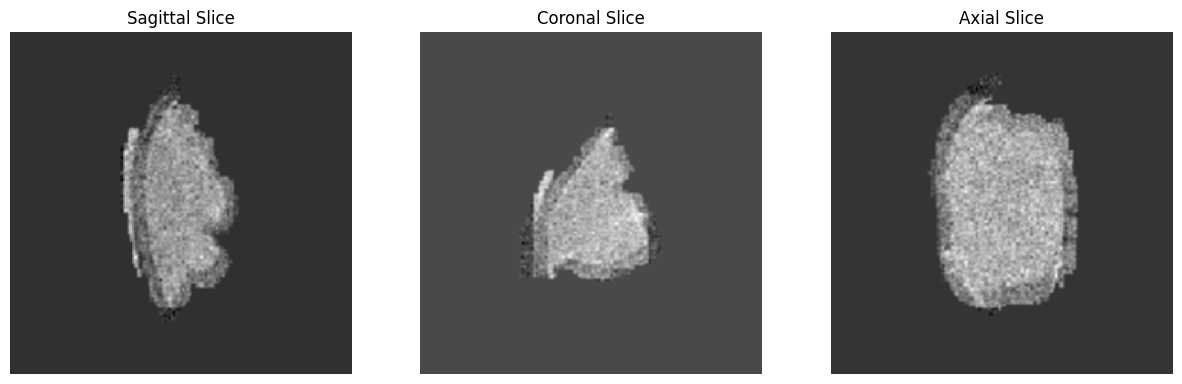

<Figure size 640x480 with 0 Axes>

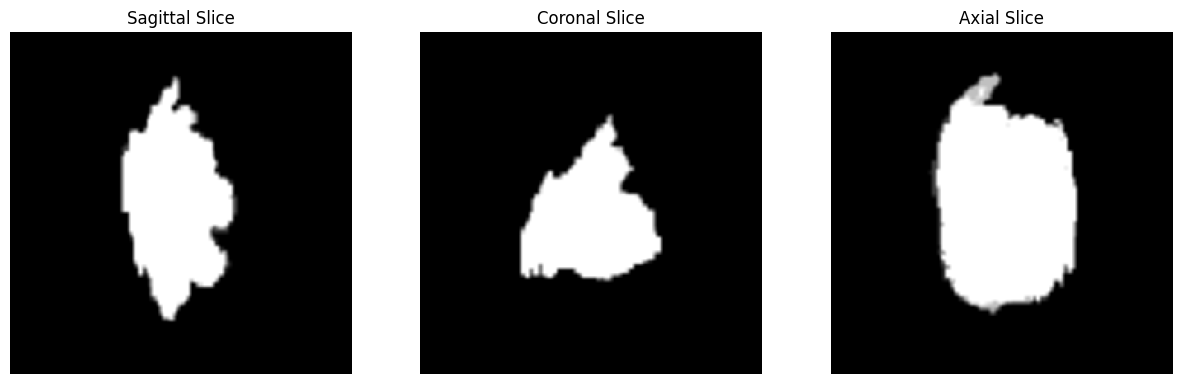

<Figure size 640x480 with 0 Axes>

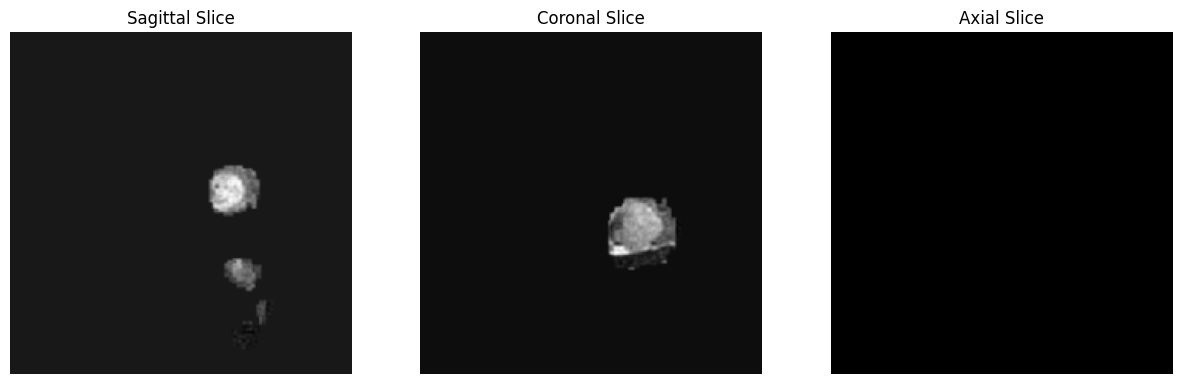

<Figure size 640x480 with 0 Axes>

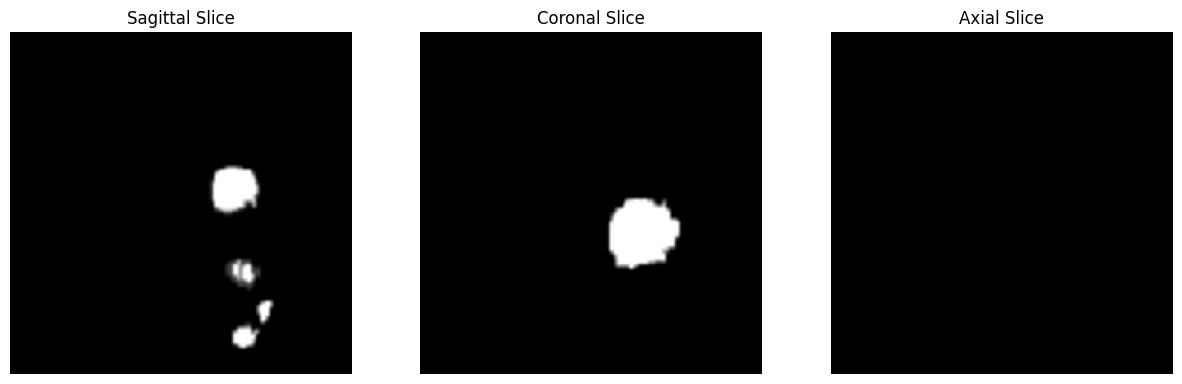

In [25]:
def visualize_transformations(training_data_loader, transformations_name:str):
    dir = Path(".", "data", transformations_name)
    dir.mkdir(parents=True, exist_ok=False)

    try:
        for i, d in enumerate(training_data_loader):
            visualize_image(d["img"], dir.joinpath(f"{i}_img"))
            visualize_image(d["mask"], dir.joinpath(f"{i}_mask"))
    except:
        dir.rmdir()
        raise

visualize_transformations(get_data_loader(TransformationsMode.AUGMENT), "gaussian_stronger")

In [170]:
# visualize_image(data["img"])
# visualize_image(data["mask"])

## Get the biggest bounding box in the dataset

First, you need to customize data loader to only make cropping

In [136]:
def get_max_bounding_box(data_loader: DataLoader) -> Tuple[np.array, ...]:
    bounding_boxes = []
    i = 0
    labels = []
    for data in data_loader:
        bounding_boxes.append(
            (data["foreground_start_coord"], data["foreground_end_coord"])
        )
        labels.append(data["label"])
        i += 1
        print(i)

    print(bounding_boxes)
    centers = []
    sizes = []
    max_length = 0
    for box in bounding_boxes:
        box_size = box[1] - box[0]
        centers.append(box[0] + box_size/2.0)
        sizes.append(box[1] - box[0])
        max_length_box = box_size.max()
        if max_length_box > max_length:
            max_length = max_length_box
    return np.array([max_length] * 3), centers, sizes, labels


loader = get_data_loader(TransformationsMode.ONLY_PREPROCESSING, ci_run=False)
max_bounding_box, centers, sizes, labels = get_max_bounding_box(loader)

yes
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
[(tensor([[126,  96,  38]], dtype=torch.int32), tensor([[181, 147,  92]], dtype=torch.int32)), (tensor([[83, 94, 21]], dtype=torch.int32), tensor([[107, 116,  39]], dtype=torch.int32)), (tensor([[76, 80, 20]], dtype=torch.int32), tensor([[128, 128,  74]], dtype=torch.int32)), (tensor([[63, 83, 31]], dtype=torch.int32), tensor([[113, 125,  77]], dtype=torch.int32)), (tensor([[ 68, 111,  23]], dtype=torch.int32), tensor([[ 87, 130,  37]], dtype=torch.int32)), (tensor([[ 28, 144,  55]], dtype=torch.int32), tensor([[ 69, 193, 

## Visualization of bounding boxes

In [137]:
def reshape_list_of_tensors(list_of_tensors):
    stacked_array = np.stack(list_of_tensors)
    return stacked_array.reshape(len(list_of_tensors), -1)

centers_reshaped = reshape_list_of_tensors(centers)
labels_reshaped = reshape_list_of_tensors(labels)

In [138]:
import plotly.express as px
df = pd.DataFrame(
    {
        "x": centers_reshaped[:, 0],
        "y": centers_reshaped[:, 1],
        "z": centers_reshaped[:, 2],
        "labels":labels_reshaped[:, 0]
    }
)
fig = px.scatter_3d(df, x='x', y='y', z='z',
              color='labels')
fig.show()
# fig.write_html("locations_distribuition.html")
# plot_3d_density(centers, labels)

In [152]:
import plotly.express as px
sizes_reshaped = reshape_list_of_tensors(sizes)
df = pd.DataFrame(
    {
        "volume": sizes_reshaped[:, 0]*sizes_reshaped[:, 1]*sizes_reshaped[:, 2],
        "labels":labels_reshaped[:, 0]
    }
)
# Create the distribution plot using Plotly Express
fig = px.histogram(df, x='volume', color='labels', marginal='rug', histnorm='probability', title='Distribution of volumes by class')

# Show the plot
fig.show()
fig.write_html("sizes_distribuition.html")
# plot_3d_density(centers, labels)

## Crop image by mask

In [52]:
def find_bounding_box(image_array: np.array) -> Tuple[np.array, np.array]:
    indices = np.argwhere(image_array == 1)
    min_indices = np.min(indices, axis=0)
    max_indices = np.max(indices, axis=0) + 1
    return min_indices, max_indices


def crop_image_by_mask(
    data_dict: Dict[str, np.array], output_size: Optional[np.array] = None
) -> Tuple[Dict[str, np.array], Tuple[np.array]]:
    assert data_dict["img"].ndim == data_dict["mask"].ndim
    mask_image_array = data_dict["mask"]
    bounding_box = find_bounding_box(mask_image_array)
    # print(bounding_box)

    # TODO how to do it for batches?
    roi_center = bounding_box[0] + (bounding_box[1] - bounding_box[0])//2
    if output_size is None:
        output_size = (bounding_box[1] - bounding_box[0])

    # TODO move if away from image
    lower_indeces = (roi_center - np.floor(output_size/2)).astype(int)
    higher_indeces = (roi_center + np.ceil(output_size/2)).astype(int)
    # print(roi_center)
    # print(output_size)
    # print(lower_indeces)
    # print(higher_indeces)

    slices = tuple(
        slice(lower_indeces[i], higher_indeces[i])
        for i in range(mask_image_array.ndim)
    )
    # print(slices)

    return data_dict["img"][slices], bounding_box

def test_crop_image():
    data_dict = {
        "img": np.array([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]]),
        "mask": np.array([[1, 0, 0, 0], [0, 0, 0, 0], [1, 1, 0, 0]]),
    }
    expected_cropped_img = np.array([[1, 2], [5, 6], [9, 10]])
    expected_bounding_box = [np.array([0, 0]), np.array([3, 2])]
    cropped_img, bounding_box = crop_image_by_mask(data_dict, output_size=None)

    print(bounding_box)
    np.testing.assert_equal(expected_cropped_img, cropped_img)
    np.testing.assert_equal(expected_bounding_box, bounding_box)


# test_crop_image()

# cropped_img, bounding_box = crop_image_by_mask(copy.deepcopy(data), None) # np.array([1,1,200,200,200])
# # visualize_image(cropped_img)
# cropped_img.shape

torch.Size([1, 1, 0, 0, 35])